# Clustering

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [15]:
torch.manual_seed(47)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Set up device

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Create data

In [16]:
n_clusters = 6
n_samples = 250

In [17]:
centroids = torch.rand(n_clusters,2)*70-35
centroids

tensor([[-31.287, -31.506],
        [ -2.263,  26.298],
        [  3.925,  20.887],
        [ 33.303, -17.624],
        [-24.716,  -4.586],
        [ 13.914,  27.182]])

In [18]:
centroids.shape

torch.Size([6, 2])

In [19]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [20]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [21]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [22]:
data[:5]

tensor([[-32.997, -33.012],
        [-30.553, -32.214],
        [-31.838, -31.558],
        [-30.234, -31.197],
        [-31.658, -32.412]])

In [23]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

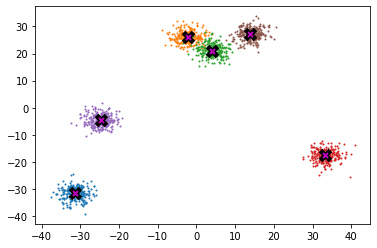

In [24]:
plot_data(centroids, data, n_samples)

## Mean shift

The algorithm is as follows:

- For each data point x in the sample X, find the distance between that point x and every other point in X
- Create weights for each point in X by using the Gaussian kernel of that point's distance to x
 - This weighting approach penalizes points further away from x
 - The rate at which the weights fall to zero is determined by the bandwidth, which is the standard deviation of the Gaussian
- Update x as the weighted average of all other points in X, weighted based on the previous step


This will iteratively push points that are close together even closer until they are next to each other.

In [28]:
data[:5]

tensor([[-32.997, -33.012],
        [-30.553, -32.214],
        [-31.838, -31.558],
        [-30.234, -31.197],
        [-31.658, -32.412]])

In [29]:
data[:5].mean(0)

tensor([-31.456, -32.079])

In [30]:
data[:5].mean(1)

tensor([-33.004, -31.383, -31.698, -30.715, -32.035])

In [32]:
tensor([-32.997, -33.012]).mean()

tensor(-33.005)

In [33]:
midp = data.mean(0)
midp

tensor([-1.202,  3.434])

In [36]:
plot_data

<function __main__.plot_data(centroids, data, n_samples, ax=None)>

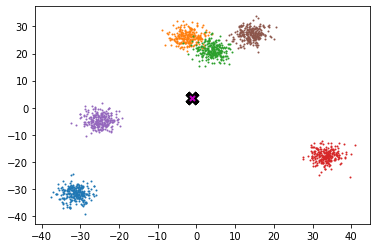

In [38]:
plot_data([midp]*6, data, n_samples)

In [39]:
# gaussian kernel #
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [40]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

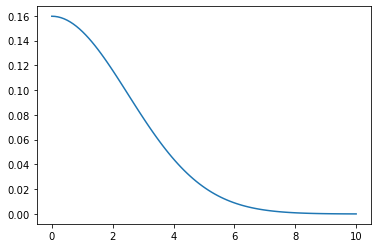

In [41]:
plot_func(partial(gaussian, bw=2.5))

In [48]:
f = partial(gaussian, bw=2.5)
f

functools.partial(<function gaussian at 0x000000A5CB01BA60>, bw=2.5)

In [49]:
f(tensor(4))

tensor(0.044)

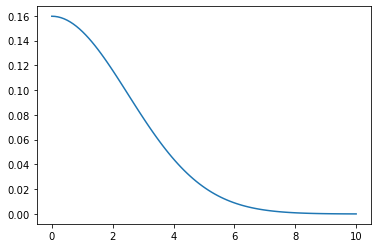

In [50]:
plot_func(lambda x: gaussian(x, bw=2.5))

In [43]:
partial

functools.partial

In our implementation, we choose the bandwidth to be 2.5.

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [44]:
def tri(d, i): return (-d+i).clamp_min(0)/i

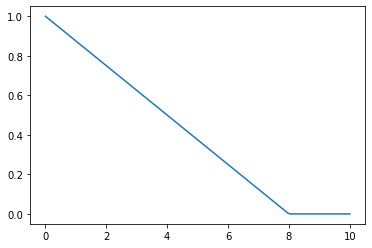

In [45]:
plot_func(partial(tri, i=8))

In [51]:
data.shape

torch.Size([1500, 2])

In [52]:
X = data.clone()
x = data[0]

In [53]:
x

tensor([-32.997, -33.012])

In [57]:
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [59]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [-2.444, -0.798],
        [-1.159, -1.454],
        [-2.763, -1.815],
        [-1.338, -0.600],
        [-2.680, -3.889],
        [-5.360, -0.911],
        [-1.058, -3.766]])

In [61]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [-2.444, -0.798],
        [-1.159, -1.454],
        [-2.763, -1.815],
        [-1.338, -0.600],
        [-2.680, -3.889],
        [-5.360, -0.911],
        [-1.058, -3.766]])

distance between points

In [67]:
((x-X)**2)[:5]

tensor([[0.000, 0.000],
        [5.974, 0.636],
        [1.344, 2.115],
        [7.635, 3.293],
        [1.792, 0.360]])

In [71]:
((x-X)**2).sum(0)

tensor([2254523.500, 2783547.500])

In [69]:
((x-X)**2).sum(1)

tensor([    0.000,     6.610,     3.459,  ...,  5557.238,  5757.894,  6029.006])

In [72]:
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 2.571, 1.860, 3.306, 1.467, 4.723, 5.437, 3.912])

In [73]:
gaussian

<function __main__.gaussian(d, bw)>

In [74]:
dist.shape

torch.Size([1500])

In [75]:
weight = gaussian(dist, 2.5)
weight

tensor([0.160, 0.094, 0.121,  ..., 0.000, 0.000, 0.000])

In [76]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [77]:
weight*X

RuntimeError: The size of tensor a (1500) must match the size of tensor b (2) at non-singleton dimension 1

In [78]:
weight[:,None].shape

torch.Size([1500, 1])

In [80]:
(weight[:,None]*X).shape

torch.Size([1500, 2])

one update

In [83]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [84]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [85]:
%time X = meanshift(data)

Wall time: 2.54 s


In [86]:
plot_data

<function __main__.plot_data(centroids, data, n_samples, ax=None)>

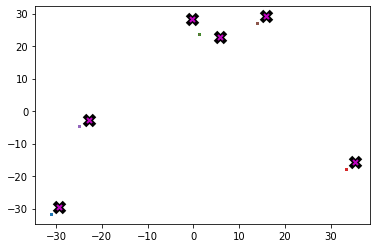

In [88]:
plot_data(centroids+2, X, n_samples)

## Animation

In [89]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [91]:
# FuncAnimation??

In [92]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [97]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=10, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm
To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [98]:
bs = 5
X=data.clone()
x= X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [99]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [100]:
dist_b(X, x)

tensor([[ 0.000,  2.571,  1.860,  ..., 74.547, 75.881, 77.647],
        [ 2.571,  0.000,  1.443,  ..., 72.385, 73.813, 75.514],
        [ 1.860,  1.443,  0.000,  ..., 72.688, 74.023, 75.787],
        [ 3.306,  1.066,  1.644,  ..., 71.392, 72.797, 74.514],
        [ 1.467,  1.123,  0.873,  ..., 73.233, 74.612, 76.347]])

In [101]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [102]:
X.shape, x.shape

(torch.Size([1500, 2]), torch.Size([5, 2]))

In [105]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [106]:
gaussian

<function __main__.gaussian(d, bw)>

In [107]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[0.199, 0.087, 0.129,  ..., 0.000, 0.000, 0.000],
        [0.087, 0.199, 0.154,  ..., 0.000, 0.000, 0.000],
        [0.129, 0.154, 0.199,  ..., 0.000, 0.000, 0.000],
        [0.051, 0.173, 0.142,  ..., 0.000, 0.000, 0.000],
        [0.152, 0.170, 0.181,  ..., 0.000, 0.000, 0.000]])

In [108]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [109]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [110]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [111]:
num

tensor([[-509.722, -511.659],
        [-682.871, -705.906],
        [-709.235, -708.995],
        [-685.356, -699.927],
        [-671.104, -682.932]])

**OR**

In [113]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[-509.722, -511.660],
        [-682.870, -705.907],
        [-709.235, -708.995],
        [-685.356, -699.927],
        [-671.104, -682.932]])

**OR**

In [114]:
weight@X

tensor([[-509.722, -511.660],
        [-682.870, -705.907],
        [-709.235, -708.995],
        [-685.356, -699.927],
        [-671.104, -682.932]])

In [117]:
weight.shape

torch.Size([5, 1500])

In [115]:
weight.sum(1, keepdim=True)

tensor([[15.866],
        [22.182],
        [22.547],
        [22.344],
        [21.411]])

In [118]:
num/div

NameError: name 'div' is not defined

In [119]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

In [120]:
data = data.to(device)

In [122]:
X=meanshift(data).cpu()
X

tensor([[-31.220, -31.546],
        [-31.220, -31.546],
        [-31.220, -31.546],
        ...,
        [ 14.013,  27.141],
        [ 14.013,  27.141],
        [ 14.013,  27.141]])

In [125]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

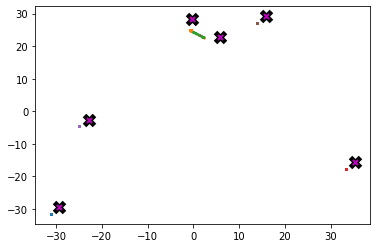

In [124]:
plot_data(centroids+2, X, n_samples)